In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from importlib import reload 
import os
from validation import inference_scoring
reload(inference_scoring)
from validation.inference_scoring import model_dirs_to_edge_vectors_list, \
    model_dirs_to_timeseries_vectors, model_dirs_to_boolean_function_vectors, \
    aggregate_classification_metric, model_dirs_to_time_taken_vector
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib import pyplot as plt
import numpy as np
import math

In [12]:
reference_dir = os.path.join("..", "data", "generated", "20210329-214112")

In [13]:
inference_results_parent_dir = os.path.join("..", "inferred_models/notebook")
inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(inference_results_parent_dir) if 
                           f.is_dir()}

In [14]:
variants = inference_variant_paths.keys()
# four vectors per variant, since the train-test split is different in each one, so 
# the reference data needs to be split accordingly.
variant_timeseries_vecs = {v: model_dirs_to_timeseries_vectors(reference_dir, p) 
                for v, p in inference_variant_paths.items()}
variant_timeseries_train_scores = {
    n: aggregate_classification_metric(vecs['ref_train'], vecs['pred_train'], accuracy_score) for 
                             n, vecs in variant_timeseries_vecs.items()}
variant_timeseries_test_scores = {
    n: aggregate_classification_metric(vecs['ref_test'], vecs['pred_test'], accuracy_score) for 
                             n, vecs in variant_timeseries_vecs.items()}

In [15]:
variant_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in inference_variant_paths.items()}

In [16]:
variant_edge_vecs = {v: model_dirs_to_edge_vectors_list(reference_dir, p) 
                for v, p in inference_variant_paths.items()}
variant_edge_scores = {
    n: aggregate_classification_metric(vecs['ref'], vecs['pred'], accuracy_score) for 
                             n, vecs in variant_edge_vecs.items()}

In [17]:
# print(variant_edge_vecs['dummy']['ref'][0][:20])
# print(variant_edge_vecs['dummy']['pred'][0][:20])
from attractor_learning import graphs
G_ref = graphs.Network.parse_cnet("C:\\Users\\Ariel\\PycharmProjects\\TimeSeriesNetworkInference\\data\\generated\\20210329-214112\\network_1\\true_network.cnet")
G_scaff = graphs.Network.parse_cnet("C:\\Users\\Ariel\\PycharmProjects\\TimeSeriesNetworkInference\\data\\generated\\20210329-214112\\network_1\\scaffold_network.cnet")
# print(len(G_ref.edges))
# print(G_ref.edges)
# print()
# print(len(G_scaff.edges))
# print(G_scaff.edges)
x = {(e[0].name, e[1].name) for e in G_ref.edges}
y = {(e[0].name, e[1].name) for e in G_scaff.edges}
print(x.difference(y))
print()
print(y.difference(x))
print(G_ref == G_scaff)

{('CYCA2;3', 'KRP1'), ('SCF', 'E2Fc'), ('SCF', 'CYCD3;1'), ('MYB3R1/4', 'CDKB1;1'), ('E2Fb', 'CDKB1;1'), ('E2Fc', 'E2Fe'), ('E2Fa', 'RBR'), ('APC/C', 'SCF'), ('E2Fa', 'E2Fb'), ('KRP1', 'SCF'), ('RBR', 'MYB77'), ('E2Fc', 'E2Fa'), ('RBR', 'APC/C'), ('CYCB1;1', 'MYB3R1/4'), ('MYB77', 'CYCA2;3'), ('E2Fb', 'E2Fe'), ('MYB3R1/4', 'CYCA2;3'), ('CDKB1;1', 'E2Fa'), ('MYB3R1/4', 'SCF'), ('APC/C', 'CYCB1;1'), ('E2Fe', 'APC/C'), ('E2Fa', 'E2Fa'), ('KRP1', 'MYB3R1/4'), ('E2Fa', 'APC/C'), ('SCF', 'KRP1'), ('RBR', 'RBR'), ('MYB3R1/4', 'MYB3R1/4'), ('MYB77', 'MYB3R1/4'), ('CDKB1;1', 'KRP1'), ('MYB77', 'CYCB1;1')}

{('E2Fa', 'CYCB1;1'), ('APC/C', 'RBR'), ('SCF', 'CDKB1;1'), ('E2Fa', 'KRP1'), ('E2Fb', 'KRP1'), ('RBR', 'CYCA2;3'), ('CDKB1;1', 'RBR'), ('E2Fa', 'CDKB1;1'), ('MYB77', 'E2Fc'), ('KRP1', 'CYCA2;3'), ('CYCB1;1', 'APC/C'), ('MYB3R1/4', 'E2Fb'), ('E2Fc', 'SCF'), ('KRP1', 'E2Fa'), ('MYB3R1/4', 'E2Fe'), ('RBR', 'MYB3R1/4'), ('CDKB1;1', 'SCF'), ('CYCA2;3', 'E2Fe'), ('SCF', 'APC/C'), ('MYB3R1/4', 'E2F

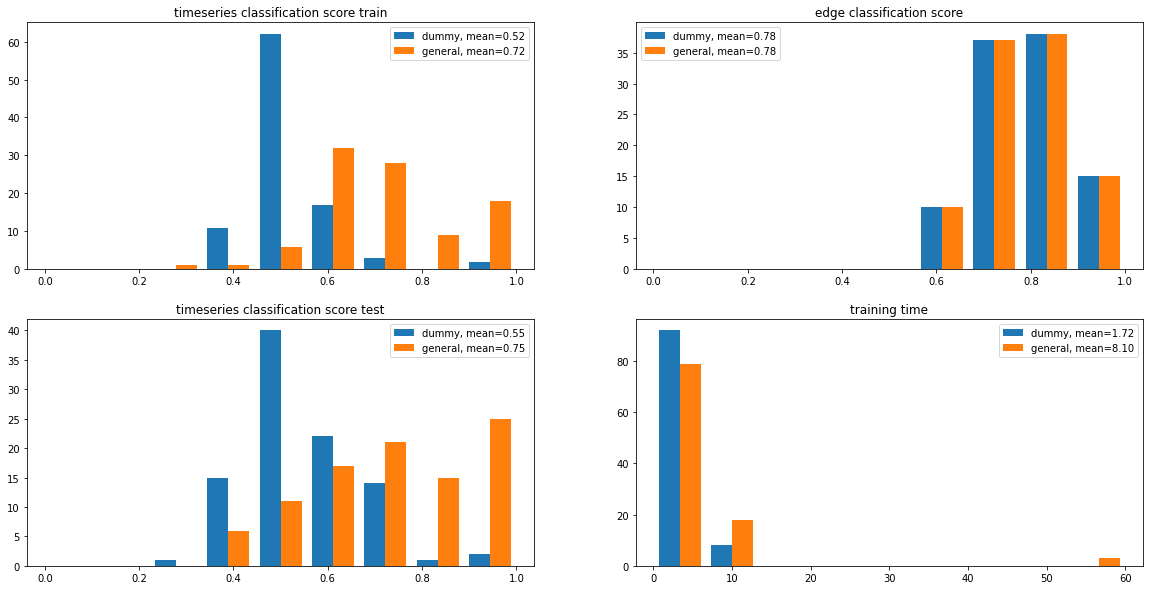

In [33]:
metrics = {'timeseries classification score train': variant_timeseries_train_scores,
           'timeseries classification score test': variant_timeseries_test_scores,
           'edge classification score': variant_edge_scores,
           'training time': variant_timings}

plt.rc('figure', figsize=(20.0, 10.0))
fig, axs = plt.subplots(2, int(math.ceil(len(metrics) / 2)))
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx % 2, int(idx / 2)]
    bins = np.linspace(0, 60 * 1 if 'training time' in title else 1, 10)
    names = []
    hist_vals = []
    for name, scores in scoring_dict.items():
        names.append("{}, mean={:.2f}".format(name, np.mean(scores)))
        hist_vals.append(np.clip(scores, bins[0], bins[-1]))
    ax.hist(hist_vals, label=names, bins=bins)
    ax.legend()
    ax.title.set_text(title)
plt.show()

1.0